In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Load Files and Initial Data Analysis

In [2]:
train = pd.read_csv(r'F:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv')
test = pd.read_csv(r'F:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')

In [77]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [81]:
print(f'Training Data shape: {train.shape}')
print(f'Testing Data shape: {test.shape}')

Training Data shape: (6036000, 8)
Testing Data shape: (4024000, 7)


In [82]:
# R and C look discrete, what are the values?
print(f'Train R values: {train.R.unique()}')
print(f'Test R values: {test.R.unique()}')
print(f'Train C values: {train.C.unique()}')
print(f'Test C values: {test.C.unique()}')

Train R values: [20 50  5]
Test R values: [ 5 50 20]
Train C values: [50 20 10]
Test C values: [20 50 10]


<AxesSubplot:title={'center':'C Value Distribution'}, xlabel='C', ylabel='Count'>

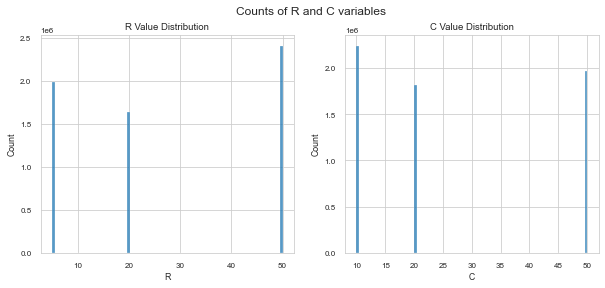

In [83]:
# what is the distribution of R and C?
fig, axs = plt.subplots(ncols=2,figsize=(10,4))
fig.suptitle('Counts of R and C variables')
axs[0].set_title('R Value Distribution')
sns.histplot(train.R,ax=axs[0])
axs[1].set_title('C Value Distribution')
sns.histplot(train.C,ax=axs[1])

## Look at a single RC combo. R=5 and C=10

In [85]:
# look at a single RC combo, just R = 5 and C = 10
train_r5 = train[train.R == 5]
train_r5c10 = train_r5[train.C == 10]
print(len(train_r5c10))
train_r5c10.head()


664960


C:\Users\Jon\AppData\Local\Temp/ipykernel_9344/3890102461.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_r5c10 = train_r5[train.C == 10]


,id,breath_id,R,C,time_step,u_in,u_out,pressure
2560,2561,39,5,10,0.000000,33.092845,0,6.189002
2561,2562,39,5,10,0.033633,100.000000,0,7.665347
2562,2563,39,5,10,0.067378,82.875875,0,14.554958
2563,2564,39,5,10,0.101031,63.513762,0,19.476108
2564,2565,39,5,10,0.134777,55.044110,0,21.655474


In [86]:
# look at length of only R=5 and C=10
len(train_r5c10)

664960

In [87]:
len(train_r5c10.breath_id.unique())
# 8312 breath samples of 80 counts for r=5, c = 10

8312

In [88]:
# Total length/unique breaths = samples per breath
664960/8312

80.0

In [89]:
# get the indicies of the breaths
breath_r5c10_idx = train_r5c10.breath_id.unique()
breath_r5c10_idx

array([    39,     43,     57, ..., 125690, 125720, 125733], dtype=int64)

### First 10 plots of the R=5 and C=10 combinations

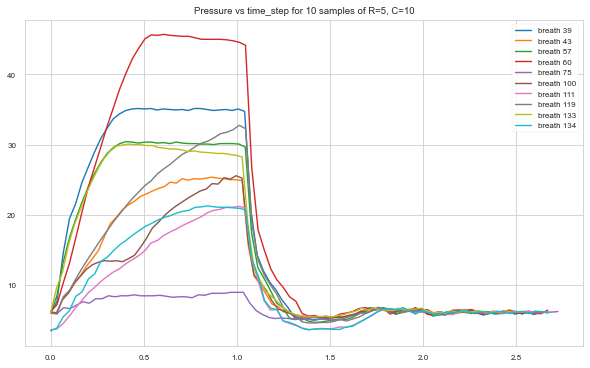

In [90]:
plt.figure(figsize=(10,6))
for i in breath_r5c10_idx[0:10]:
    temp_data = train_r5c10[train_r5c10.breath_id == i]
    plt.plot(temp_data['time_step'],temp_data['pressure'],label=f'breath {i}')
    #plt.plot(temp_data['time_step'],temp_data['u_in'])
    plt.legend()
    plt.title('Pressure vs time_step for 10 samples of R=5, C=10')

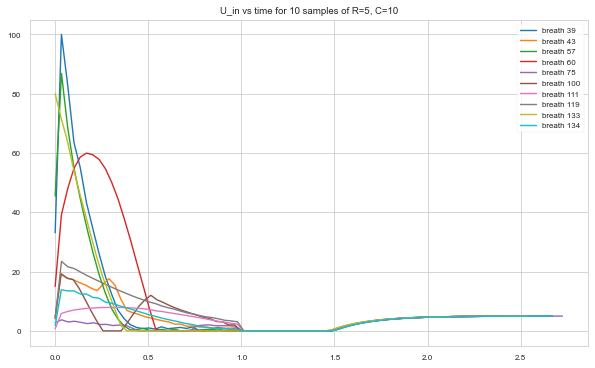

In [91]:
plt.figure(figsize=(10,6))
for i in breath_r5c10_idx[0:10]:
    temp_data = train_r5c10[train_r5c10.breath_id == i]
    #plt.plot(temp_data['time_step'],temp_data['pressure'])
    plt.plot(temp_data['time_step'],temp_data['u_in'],label=f'breath {i}')
    plt.legend()
    plt.title('U_in vs time for 10 samples of R=5, C=10')

### How many exhales points are there?
* Roughly the last 50 points are exhale

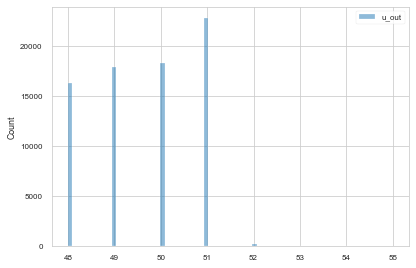

In [164]:
exhale = train.groupby('breath_id')[['u_out']].agg('sum')
sns.histplot(exhale);

### Maximum time of each breath
* Around 2.74 seconds long on average
* There are a few obvious outliers, up to ~2.95 seconds
    * Determine how to deal with these

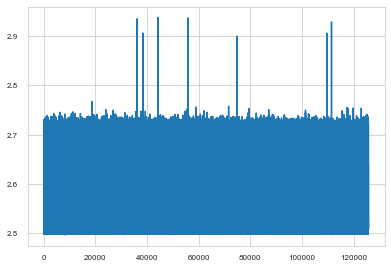

In [165]:
max_time = train.groupby('breath_id')[['time_step']].max()
plt.plot(max_time.index,max_time.values);

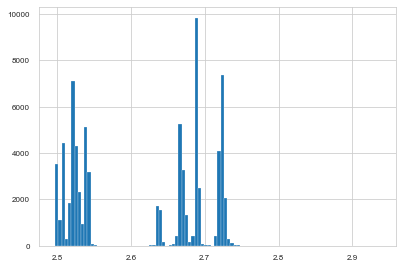

In [167]:
plt.hist(max_time,bins=100);
# why different than when I look at the plot below?

In [157]:
# time step start at 0 always?
min_times = train.iloc[0:75450:80,4]  # time step is in col 4
max_times = train.iloc[79:75450:80,4]
min_times.unique()
# Yes, time always starts at 0

array([0.])

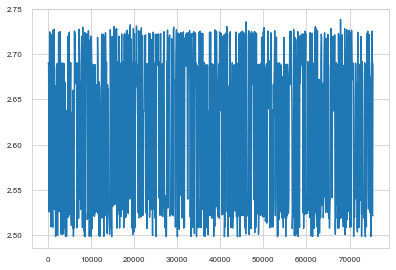

In [158]:
plt.plot(max_times)
# why does this not exactly match the above?

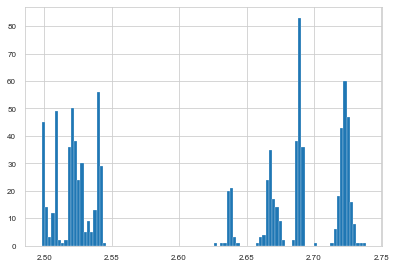

In [163]:
# Look at distribution of stopping values 
plt.hist(max_times,bins=100);

### Find total number of breaths in training data
* There are 75450 total breaths
* There are 80 samples per breath

In [150]:
# How many total breaths are there?
tot_breaths = len(train.breath_id.unique())
print(f'Total breaths = {tot_breaths}')
# there are 75450 unique breaths of 80 counts each
print(f'Counts per breath = {6036000/75450}')

Total breaths = 75450
Counts per breath = 80.0


In [99]:
# function to plot a certain breaths time series
def plot_breath(id=0):
    # todo: check if > max
    
    # generate start stop points
    start = 80 * id
    stop = start + 80
    series = train.iloc[start:stop,:]
    
    r_val = series.R.iloc[0]
    c_val = series.C.iloc[0]
    
    plt.style.use('seaborn-paper')
    plt.figure()
    plt.plot(series.time_step,series.u_in, label='u_in')
    plt.plot(series.time_step,series.u_out,label = 'u_out')
    plt.plot(series.time_step,series.pressure, label = 'pressure')
    plt.legend()
    plt.title(f'Time series plot for breath id={id}, R={r_val}, C={c_val}')
    plt.savefig(f'Breath_plot id={id}, R={r_val}, C={c_val}.png',dpi=300)
    

### Plot individial breaths

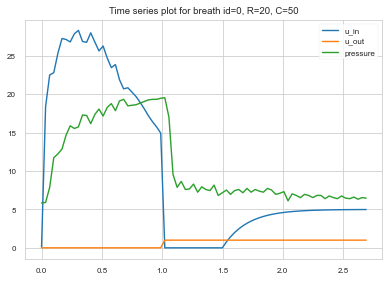

In [65]:
# plot first 10 breaths
#print(plt.style.available)
for i in range(1):
    plot_breath(i)

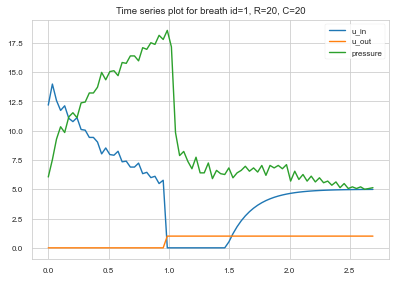

In [66]:
plot_breath(1)

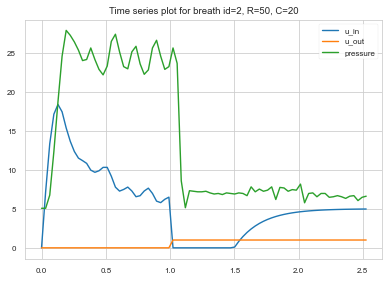

In [67]:
plot_breath(2)

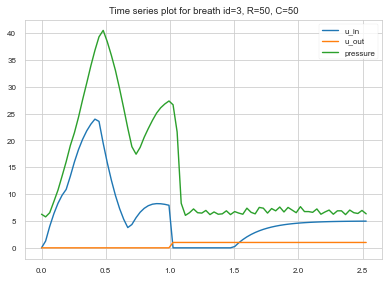

In [68]:
plot_breath(3)

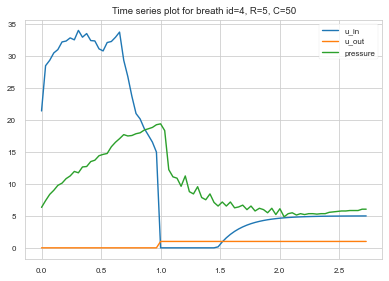

In [69]:
plot_breath(4)

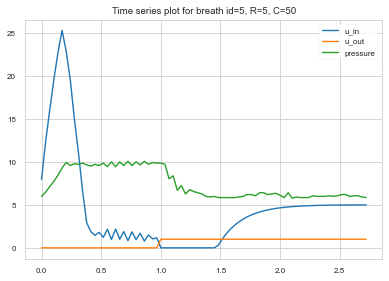

In [70]:
plot_breath(5)

In [100]:
# get single breath (id must exist...there are some that are missing)
def get_breath(df,id):
    # generate start stop points
    start = 80 * id
    stop = start + 80
    return train.iloc[start:stop,:]
    

In [236]:
id1 = get_breath(train,0)
dt = np.diff(id1.time_step)  #make a differential time step
dt_list = list(dt)
dt_list.append(dt.mean())
id1['dt'] = dt_list

vol = np.zeros(len(id1))  # integrate to get volume
vol[0] = 6 # mean of all
for i in range(len(id1)-1):
    vol[i+1] = vol[i] + (id1.u_in.iloc[i]* id1.dt.iloc[i])#*id1.C.iloc[0]/id1.R.iloc[0]
id1 = id1.reset_index()
id1['vol'] = vol

C:\Users\Jon\AppData\Local\Temp/ipykernel_9344/1103917893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id1['dt'] = dt_list


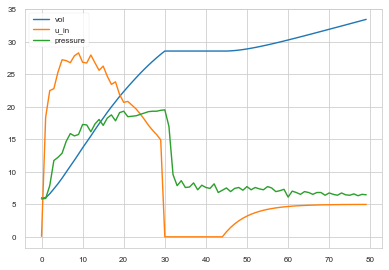

In [237]:
plt.plot(id1.vol,label='vol')
plt.plot(id1.u_in,label='u_in')
plt.plot(id1.pressure,label='pressure')
plt.legend()

19.54641006805627

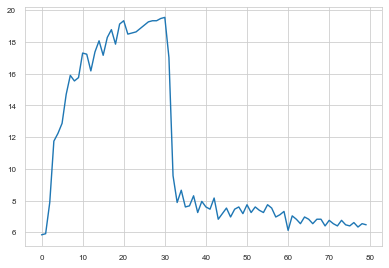

In [170]:
plt.plot(id1.pressure)
id1.pressure.max()
#max pressure is 18.5


In [258]:
# What is the max pressure for each c value?
c_max = train.groupby('C').pressure.max()  # returns a series object
c_max.head()
# not much variation 10: 64.82, 20: 64.82, 50: 62.3
# are these outliers?

C
10    64.820992
20    64.820992
50    62.290115
Name: pressure, dtype: float64

In [245]:
train.groupby('R').pressure.max()
# seems inconclusive here too

R
5     56.595641
20    50.830865
50    64.820992
Name: pressure, dtype: float64

In [260]:
train_c20 = train[train.C == 20]

## Outlier identification

### Pressure - Starting and stopping values

First Pressure values mean: 5.811202873136634, std: 1.048151137750573
Ending Pressure value mean: 6.092681783414324, std: 0.8017635937985323


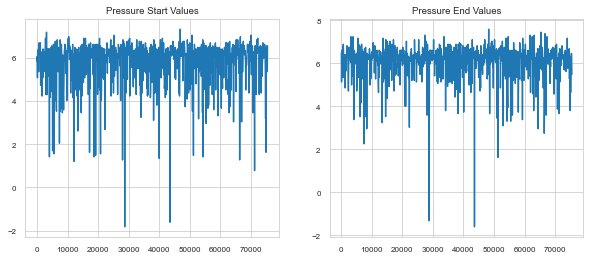

In [172]:
# look at starting positions = pressure at first value of each breath
p_start = train.pressure.iloc[0:tot_breaths:80]
p_end = train.pressure.iloc[79:tot_breaths:80]
print(f'First Pressure values mean: {p_start.mean()}, std: {p_start.std()}')
print(f'Ending Pressure value mean: {p_end.mean()}, std: {p_end.std()}')

fix,ax = plt.subplots(ncols=2,figsize=(10,4))
fig.suptitle('Pressure Starting and Stopping Values')
ax[0].set_title('Pressure Start Values')
ax[0].plot(p_start)
ax[1].set_title('Pressure End Values')
ax[1].plot(p_end);


In [290]:
# There are a few outliers.  Need to take care of them or at least take a look at them.
low_vals = train.pressure.loc[train.pressure < 0]
low_vals
# says there are 3713 values < 0, that doesn't make sens because I only see 2 in the plot

28720     -1.825442
28721     -1.825442
28722     -1.755140
28723     -1.825442
28724     -1.684838
             ...   
5979915   -0.700608
5979916   -0.770910
5979917   -0.841212
5979918   -0.770910
5979919   -0.841212
Name: pressure, Length: 3713, dtype: float64

In [168]:
5979840/80

74748.0

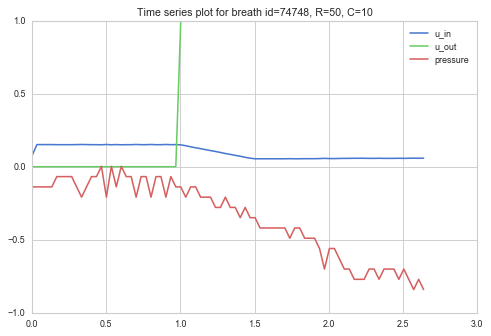

In [157]:
plot_breath(int(5979915/80))
# this ending value is < 0. but dont see it on the above plot at position 74748. 
# is this an indexing issue?

In [175]:
# look at minimum pbb = minimum pressure per breath
min_ppb = train.groupby(train.breath_id).pressure.min()
min_ppb

breath_id
1         5.837492
2         4.993866
3         5.064168
4         5.767190
5         4.853262
            ...   
125740    5.345377
125742    5.626585
125743    5.485981
125745    5.837492
125749    3.798729
Name: pressure, Length: 75450, dtype: float64

In [182]:
min_ppb.iloc[74748]  #this aligns with the plot above

-0.8412121127964142

In [184]:
# how many have pressures that drop below 0?
len(min_ppb[min_ppb < 0])
# 73 records with min pressure below 0 
# in this case maybe just remove them.

73

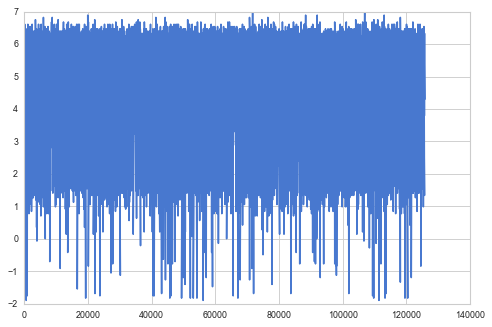

In [186]:
plt.plot(min_ppb)

In [188]:
# next look at max
max_ppb = train.groupby('breath_id').pressure.max()
max_ppb

breath_id
1         19.546410
2         18.562180
3         27.842063
4         40.496449
5         19.405806
            ...    
125740    15.398583
125742    34.872278
125743    11.110153
125745    27.420250
125749    30.091732
Name: pressure, Length: 75450, dtype: float64

In [191]:
max_ppb.max()

64.8209917386395

In [194]:
max_ppb[max_ppb < 0]
len(max_ppb[max_ppb < 0])
#There are 34 instances of max_ppb dropping below 0.
# I think probably deleting these rows would be fine.

34

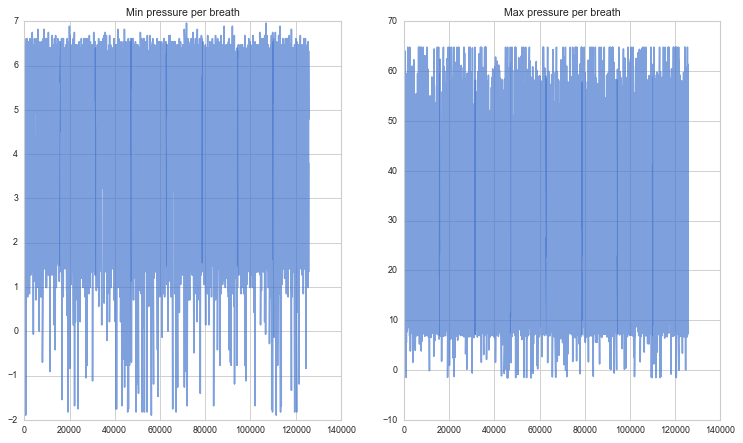

In [223]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(min_ppb,alpha=.7)
plt.title('Min pressure per breath')
plt.subplot(1,2,2)
plt.title('Max pressure per breath')
plt.plot(max_ppb,alpha=.7)
# actually anything less than about 8 loos like an anomoly

In [230]:
# to remove, need to find index of first row and then delete 80 of them.
min_ppb[min_ppb < 0]
#argmin says 359, min says -1.896, but min_ppb[359] displays 5.48?  
# But min_ppb.iloc[359] is  correct (-1.89)


breath_id
542      -1.895744
851      -1.755140
3928     -0.067889
7949     -0.700608
11216    -0.911514
            ...   
118131   -1.333327
119582   -1.825442
120445   -1.825442
121570   -1.192723
124575   -0.841212
Name: pressure, Length: 73, dtype: float64

In [237]:
min_ppb.index.max()
# .index.max() = 125749, but len(min_ppb) = 75450
# when I pringt out, it says 125749 long

125749

In [238]:
min_ppb[542]

-1.895744294564641

In [239]:
len(min_ppb)

75450

In [242]:
min_ppb[124575]

-0.8412121127964142

In [245]:
min_ppb.index.name
# so indexed by breath_id, so 

'breath_id'

In [249]:
#min_ppb[542] # this only works if the key is in the breath_id index, so will error sometimes
# is is not the position in the array, use .iloc for that
min_ppb.iloc[359]

-1.895744294564641

### Need to remove anomoly rows 

In [ ]:
# remove anomoly rows

# Add features

In [178]:
train['RCprod'] = train.R*train.C
train['RCdiv'] = train.R/train.C

In [179]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,RCprod,RCdiv
0,1,1,20,50,0.000000,0.083334,0,5.837492,1000,0.4
1,2,1,20,50,0.033652,18.383041,0,5.907794,1000,0.4
2,3,1,20,50,0.067514,22.509278,0,7.876254,1000,0.4
3,4,1,20,50,0.101542,22.808822,0,11.742872,1000,0.4
4,5,1,20,50,0.135756,25.355850,0,12.234987,1000,0.4


Text(0.5, 1.0, 'Plot of breath_id=1, showing dt spike at index 20')

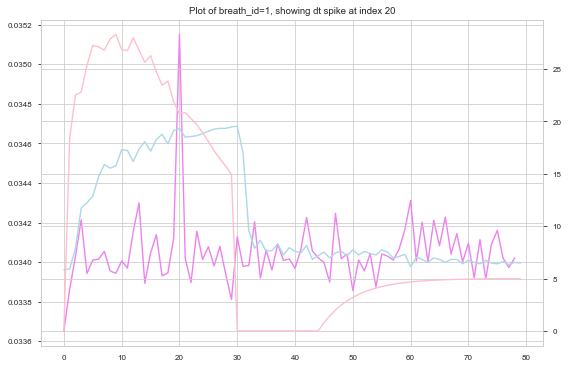

In [226]:
# compute derivatives and integrals
# dt, compute d_u_in, d_pressure?
b1 = train.groupby('breath_id').get_group(1)

time = np.array(b1.time_step)
dt = np.diff(time)

# plot on separate axis
fig, ax1 = plt.subplots(figsize=(9, 6))
ax1.plot(dt,color='violet')
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.plot(b1.pressure,'lightblue')
ax2.plot(b1.u_in,'pink')
plt.title('Plot of breath_id=1, showing dt spike at index 20')

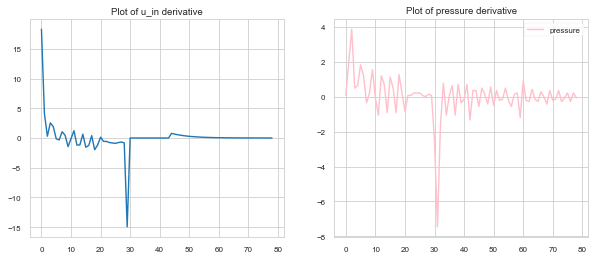

In [223]:
# look at differential u_in and pressure
d_uin = np.diff(b1.u_in)
d_pressure = np.diff(b1.pressure)

# plot on separate axis
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(d_uin,label='U_in')
ax[0].set_title('Plot of u_in derivative')
ax[1].plot(d_pressure,color='pink',label='pressure')
ax[1].set_title('Plot of pressure derivative')
plt.legend()

In [202]:
b1.u_in.iloc[0]


0.0833340056346443

In [303]:
# can I use the info above to figure out a delay time?
# yes, should do that.  Get mins of both arrays and compute dt

In [188]:
# check time delta
print(np.argmin(d_uin))
print(np.argmin(d_pressure))
# there is a two step delay (31-29)

29
31


Text(0.5, 1.0, 'Plot of dt in breath_id=2, no spike at index 20')

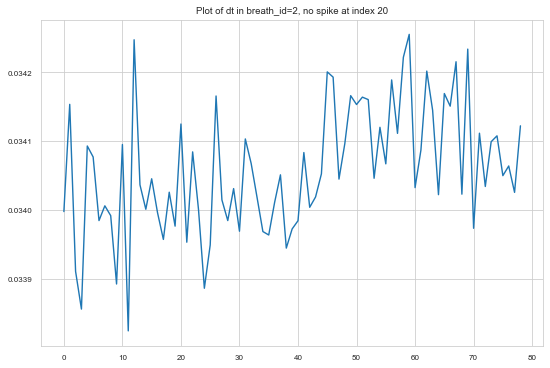

In [190]:
# look at breath2 differentials:
b2 = train.groupby('breath_id').get_group(2)
dt = np.diff(b2.time_step)
d_uin = np.diff(b2.u_in)
d_pressure = np.diff(b2.pressure)

# plot
fig, ax1 = plt.subplots(figsize=(9, 6))
ax1.plot(dt)
# # Instantiate a second axes that shares the same x-axis
# ax2 = ax1.twinx()  
# ax2.plot(b2.pressure)
# ax2.plot(b2.u_in)
plt.title('Plot of dt in breath_id=2, no spike at index 20')

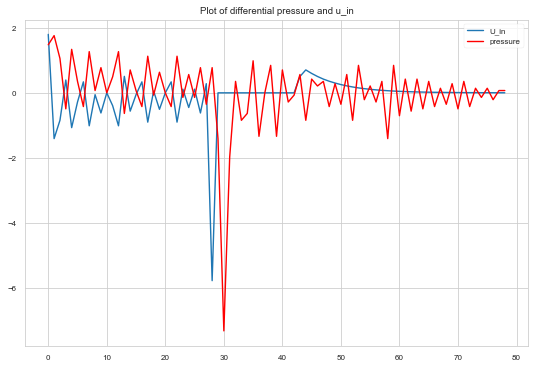

In [191]:
# look at differential plot of u_in and pressure
fig, ax1 = plt.subplots(figsize=(9, 6))
ax1.plot(d_uin,label='U_in')
ax1.plot(d_pressure,color='r',label='pressure')
plt.title('Plot of differential pressure and u_in')
plt.legend()


In [192]:
# check time delta
print(np.argmin(d_uin))
print(np.argmin(d_pressure))
# there is a two step delay (30-28)
# Pressure is two steps ahead

28
30


In [263]:
lag = id1.u_in.shift(2,fill_value=0)


In [264]:
lag


0      0.000000
1      0.000000
2      0.083334
3     18.383041
4     22.509278
        ...    
75     4.964136
76     4.969730
77     4.974474
78     4.978481
79     4.981847
Name: u_in, Length: 80, dtype: float64